In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.scipy.stats import norm
import jax_cosmo as jc

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

from dynesty import NestedSampler, DynamicNestedSampler
from dynesty.utils import resample_equal

from tqdm import tqdm

np.random.seed(42)


catalog_filename = "/Users/maddycrossparkin/Downloads/16651.csv.bz2"
chunksize = 10000
chunks = []

columns_needed = ['ra', 'dec', 'z', 'abs_mag_r']
for chunk in pd.read_csv(catalog_filename, sep=",", comment='#', na_values=r'\N', compression='bz2', chunksize=chunksize, usecols = columns_needed):
    chunks.append(chunk)

data_MICECAT = pd.concat(chunks, ignore_index=True)
data_MICECAT = data_MICECAT.sort_values('z')

catalog_filename = "/Users/maddycrossparkin/Downloads/22495.csv.bz2"
chunksize = 10000
chunks = []
columns_needed = ['r_des_true', 'i_des_true', 'g_des_true', 'z']
for chunk in pd.read_csv(catalog_filename, sep=",", comment='#', na_values=r'\N', compression='bz2', chunksize=chunksize, usecols = columns_needed):
    chunks.append(chunk)

data_MICECAT_mags = pd.concat(chunks, ignore_index=True)
data_MICECAT_mags = data_MICECAT_mags.sort_values(by=['z'])


data_MICECAT['r_des_true'] = data_MICECAT_mags['r_des_true']
data_MICECAT['i_des_true'] = data_MICECAT_mags['i_des_true']
data_MICECAT['g_des_true'] = data_MICECAT_mags['g_des_true']
data_MICECAT = data_MICECAT[data_MICECAT['z'] <= 0.7]

/Users/maddycrossparkin/miniconda3/envs/maddyenv_local/lib/python3.12/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


In [35]:
jax.config.update("jax_enable_x64", True)

key = jax.random.PRNGKey(42)
speed_of_light = 299792.458
Om0 = 0.25
true_cosmology = FlatLambdaCDM(H0=70., Om0=Om0)

def dL_at_z_H0(z_array, H0, Om0):
    """Compute luminosity distance d_L(z) for a given redshift array and cosmology (H0, Om0) (JAX friendly)"""
    c = 299792.458 

    def H_z(z):
        return H0 * jnp.sqrt(Om0 * (1 + z)**3 + (1 - Om0))

    def comoving_distance(z):
        z_grid = jnp.linspace(0, z, 100) 
        integrand = c / H_z(z_grid)
        return jnp.trapezoid(integrand, z_grid)

    if jnp.ndim(z_array) == 0:
        D_C = comoving_distance(z_array)
        d_L = (1 + z_array) * D_C
        return d_L
    else:
        D_C_array = jax.vmap(comoving_distance)(z_array)
        d_L_array = (1 + z_array) * D_C_array
        return d_L_array


def z_at_dL_H0(dL_target, H0, zinterp):
    """Invert d_L(z) relation to estimate z for a given luminosity distance via interpolation."""
    dL_grid = dL_at_z_H0(zinterp, H0, Om0)
    idx = jnp.argsort(dL_grid)
    dL_sorted = dL_grid[idx]
    z_sorted = zinterp[idx]
    z_est = jnp.interp(dL_target, dL_sorted, z_sorted)
    return z_est

def E(z, Om):
    """Dimensionless Hubble parameter E(z) = H(z)/H0."""
    return jnp.sqrt(Om*(1+z)**3 + (1-Om))


def dL_by_z_H0(z,dL,h0,Om0):
    """Compute derivative dL/dz under a flat ΛCDM model."""
    return dL/(1+z) + speed_of_light*(1+z)/(h0*E(z,Om0))


def dvdz_jax(z, H0, Om0):
    """Compute comoving volume element dV/dz (in Mpc3) (JAX friendly)."""
    c = 299792.458
    H_z = H0 * jnp.sqrt(Om0 * (1 + z)**3 + (1 - Om0))
    def comoving_distance(z_val):
        z_grid = jnp.linspace(0, z_val, 200)
        integrand = c / (H0 * jnp.sqrt(Om0 * (1 + z_grid)**3 + (1 - Om0)))
        return jnp.trapezoid(integrand, z_grid)

    chi = jax.vmap(comoving_distance)(z)
    dvdz = 4 * jnp.pi * (c / H_z) * chi**2
    return dvdz


def prepare_mice_data(data, loc_area, direction):
    ra, dec = direction
    """Filter MICEcat within a circular localisation area of given area around (ra, dec)."""
    radius = np.sqrt(loc_area/np.pi)
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    
    angular_distance = np.arccos(np.sin(np.radians(data['dec'])) * np.sin(dec_rad) + np.cos(np.radians(data['dec'])) * np.cos(dec_rad) * np.cos(np.abs(np.radians(data['ra']) - ra_rad)))
    angular_distance_deg = np.degrees(angular_distance)
    filtered_data = data[angular_distance_deg <= radius]
        
    return filtered_data

def random_directions(data):
    """Generate a random sky direction (ra, dec) within the bounds of a catalog."""
    randomdirections = []
    minra, maxra = np.min(data['ra']), np.max(data['ra'])
    mindec, maxdec = np.min(data['dec']), np.max(data['dec'])
    randra = np.random.uniform(minra, maxra)
    randdec = np.random.uniform(mindec, maxdec)
    randomdirections.append((randra, randdec))
    return randomdirections

def draw_gw_events(Ndet,sigma_dl,dl_thr,galaxies_list,true_cosmology,zcut_rate):
    """Simulate gravitational-wave detections from a galaxy catalog with observed luminosity distance threshold and true redshift cut."""
    np.random.seed(42)
    Ngw=100000
    eligible = galaxies_list[galaxies_list['z'] <= zcut_rate]
    chosen_idx = np.random.choice(eligible.index, size=Ngw, replace=True)
    chosen_galaxies = eligible.loc[chosen_idx]
    
    gw_redshift = chosen_galaxies['z'].to_numpy()
    gw_true_ra = chosen_galaxies['ra'].to_numpy()
    gw_true_dec = chosen_galaxies['dec'].to_numpy()

    gw_true_dl = true_cosmology.luminosity_distance(gw_redshift).to('Mpc').value
    std_dl = gw_true_dl * sigma_dl
    gw_obs_dl = np.random.randn(len(gw_true_dl)) * std_dl + gw_true_dl
    gw_detected = np.where(gw_obs_dl < dl_thr)[0][:Ndet]

    return  gw_obs_dl[gw_detected], gw_true_dl[gw_detected], gw_redshift[gw_detected], std_dl[gw_detected], gw_true_ra[gw_detected], gw_true_dec[gw_detected]

def gen_dlposterior_samples(Nsamples, dl_true, sigma_dl):
    """Generate posterior samples of luminosity distance given true dL and uncertainty."""
    sigma_dL = sigma_dl * dl_true
    samples = jax.random.normal(key, shape=(Nsamples,)) * sigma_dL + dl_true
    return samples
   
def sample_ra_dec_from_area_circular(ra_center_deg, dec_center_deg, area_deg2, Nsamples):
    """Sample random (RA, Dec) positions in a Gaussian localisation area area centered on (ra_center, dec_center)."""
    key_x, key_y = jax.random.split(key)
    sigma_deg = np.sqrt(area_deg2 / (-2.0 * np.pi * np.log(1.0 - 0.95)))

    x = jax.random.normal(key_x, shape=(Nsamples,)) * sigma_deg
    y = jax.random.normal(key_y, shape=(Nsamples,)) * sigma_deg

    dec0_rad = jnp.deg2rad(dec_center_deg)
    cos_dec0 = jnp.clip(np.cos(dec0_rad), 1e-6, 1.0)
    dra_deg  = x / cos_dec0
    ddec_deg = y

    ra_deg  = (ra_center_deg + dra_deg) % 360.0
    dec_deg = jnp.clip(dec_center_deg + ddec_deg, -90.0, 90.0)

    return jnp.deg2rad(ra_deg), jnp.deg2rad(dec_deg)




## Checking if jax and astropy give consistent $z$ to $d_L$ results

In [36]:
import numpy as np, astropy.units as u
from astropy.cosmology import FlatLambdaCDM

z = np.linspace(0.01, 1.0, 10)
H0, Om0 = 70, 0.25

dL_astropy = FlatLambdaCDM(H0=H0, Om0=Om0).luminosity_distance(z).to(u.Mpc).value
dL_jax = np.asarray(dL_at_z_H0(z, H0, Om0))

print(np.allclose(dL_astropy, dL_jax, rtol=1e-4))


True


In [37]:
H0, Om0 = 70, 0.25
z = np.linspace(0.01, 1.0, 10)
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)
dvdz_astropy = 4*np.pi*cosmo.differential_comoving_volume(z).to(u.Mpc**3/u.sr).value
dvdz_jax_vals = np.asarray(dvdz_jax(z, H0, Om0))
print(np.allclose(dvdz_astropy, dvdz_jax_vals, rtol=1e-4))


True


## 3 Parameters and Rejecting Samples

In [38]:
#generating the apex of each cone that defines each localisation area
dirs = []
for i in tqdm(range(200)):
    dirs.extend(random_directions(data_MICECAT)) 

100%|██████████| 200/200 [00:00<00:00, 330.83it/s]


In [39]:
# the following functions are very similar to your original code but jaxified and changed to accommodate f3. 
# note, I compute f3 in these functions just for plotting purposes, f3 isnt actually sampled

def puniverse(event, raobs, decobs, zobs, H0, f1, f2):
    f3 = 1 - (f1 + f2)
    zgal = event["z"]
    dL = dL_at_z_H0(zgal, H0, Om0)
    rmag, gmag, imag = event["r_des_true"], event["g_des_true"], event["i_des_true"]

    mags = jnp.stack([rmag, gmag, imag])
    fluxes = 3.0128e28 * 10**(-0.4*(mags - 5*jnp.log10(dL) - 25))
    weights = fluxes / jnp.sum(fluxes, axis=1, keepdims=True)

    prob_ra  = norm.pdf(raobs[:, None], event["ra_mean"][None, :], event["ra_sigma"][None, :])
    prob_dec = norm.pdf(decobs[:, None], event["dec_mean"][None, :], event["dec_sigma"][None, :])
    prob_z   = norm.pdf(zobs[:, None],  event["z_mean"][None, :],  event["z_sigma"][None, :])
    
    w_mix = f1 * weights[0] + f2 * weights[1] + f3 * weights[2]
    p_matrix = w_mix[None, :] * prob_ra * prob_dec * prob_z
    return p_matrix / event["ra_mean"].size

def prior_transform(theta):
    H0_min, H0_max = 5, 200
    f1_min, f1_max = 0, 1
    f2_min, f2_max = 0, 1

    H0_, f1_, f2_, f3_ = theta

    H0 = H0_ * (H0_max - H0_min) + H0_min
    f1 = f1_ * (f1_max - f1_min) + f1_min
    f2 = f2_ * (f2_max - f2_min) + f2_min

    f3 = 1 - (f1 + f2)

    return (H0, f1, f2, f3)


def log_likelihood_event(theta, event, zinterp):
    H0, f1, f2, f3 = theta
    if (f1 < 0) or (f2 < 0) or (f1 + f2 > 1):
        return -jnp.inf
    
    zobs = z_at_dL_H0(event["dLobs"], H0, zinterp)
    weights = (dvdz_jax(zobs, H0, Om0) / dL_by_z_H0(zobs, event["dLobs"], H0, Om0) / (1 + zobs) / event["dLobs"]**2 / jnp.cos(event["decobs"]))
    p_matrix = puniverse(event, event["raobs"], event["decobs"], zobs, H0, f1, f2)
    weights_0 = jnp.sum(p_matrix * weights[:, None], axis=1)
    return jnp.log(jnp.mean(weights_0)) - 3 * jnp.log(H0)


def log_likelihood_combined(theta, dirs_data, zinterp):
    fn = lambda e: log_likelihood_event(theta, e, zinterp)
    return jnp.sum(jnp.array([fn(e) for e in dirs_data]))

In [40]:
loc = 1
sigma_zi = 1e-2
sigma_dL = 0.1
sigma_dec = 0.01
sigma_ra = 0.01
dl_thr = 1550
Nsamples = 256

Om0 = 0.25
dirs_data = []

zinterp = np.linspace(0,0.7,5000)

for ind, direction in enumerate(tqdm(dirs[0:200])):
    redshift_data_MICE = prepare_mice_data(data_MICECAT, loc, direction)
    
    z = jnp.asarray(redshift_data_MICE['z'].to_numpy())
    dz = sigma_zi * z
    
    ra = jnp.deg2rad(jnp.asarray(redshift_data_MICE['ra'].to_numpy()))
    dec = jnp.deg2rad(jnp.asarray(redshift_data_MICE['dec'].to_numpy()))

    raobs, decobs = sample_ra_dec_from_area_circular((direction[0]), (direction[1]), loc, Nsamples)

    gw_obs_dl, gw_true_dl, gw_redshift, std_dl, ra_gw, dec_gw = draw_gw_events(Ndet=1, sigma_dl=sigma_dL, dl_thr=dl_thr, galaxies_list=redshift_data_MICE, true_cosmology=true_cosmology, zcut_rate=0.7)
    dLobs = gen_dlposterior_samples(Nsamples, gw_true_dl, sigma_dL)

    dirs_data.append({
    "raobs": jnp.asarray(raobs),
    "decobs": jnp.asarray(decobs),
    "dLobs": jnp.asarray(dLobs),
    "z": jnp.asarray(z),
    
    "r_des_true": jnp.asarray(redshift_data_MICE['r_des_true'].to_numpy()),
    "g_des_true": jnp.asarray(redshift_data_MICE['g_des_true'].to_numpy()),
    "i_des_true": jnp.asarray(redshift_data_MICE['i_des_true'].to_numpy()),
    
    "ra_mean": ra,
    "ra_sigma": jnp.full_like(ra, sigma_ra),
    "dec_mean": dec,
    "dec_sigma": jnp.full_like(dec, sigma_dec),
    "z_mean": z,
    "z_sigma": dz
})

100%|██████████| 200/200 [00:18<00:00, 10.90it/s]


In [41]:
ndims = 4
nlive = 50
nprocesses = 128

labels = [r'$H_0$', r'$f_1$', r'$f_2$', r'$f_3$']

bound = 'multi'
sample = 'rwalk'

loglike = lambda theta: log_likelihood_combined(theta, dirs_data, zinterp)
dsampler = NestedSampler(loglike, prior_transform, ndims, bound='multi', sample='rwalk', nlive=nlive)
dsampler.run_nested(dlogz=0.01)


608it [3:51:50, 22.88s/it, +50 | bound: 63 | nc: 1 | ncall: 13192 | eff(%):  5.007 | loglstar:   -inf < -2223.597 <    inf | logz: -2231.704 +/-  0.340 | dlogz:  0.000 >  0.010]


Marginalised evidence (using dynamic sampler) is -2231.7039024877 ± 0.34507276538285386
Number of posterior samples (using dynamic sampler) is 658


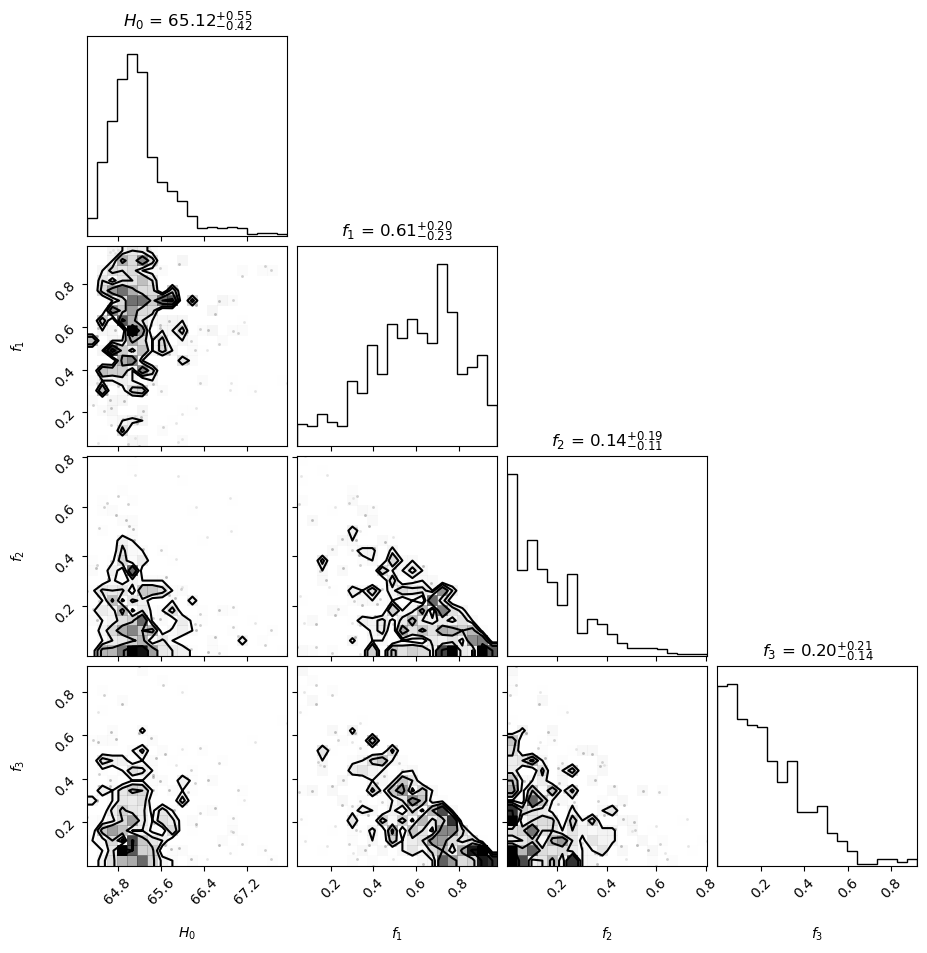

In [43]:
import corner
dres = dsampler.results

dlogZdynesty = dres.logz[-1]
dlogZerrdynesty = dres.logzerr[-1]

print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)

print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))

fig = corner.corner(dpostsamples, labels=labels, hist_kwargs={'density': True}, show_titles=True)
plt.show()


## Dirichlet Mixture

For a Dirichlet mixture, the normalized mixture fractions are obtained from uniform random variables $u_i$ as $$f_i=\frac{-\ln(1-u_i)}{\sum_j -\ln(1-u_j)}$$

In [44]:
# the only changes to the functions in the previous section come into prior_transform, and now we can remove the rejection conditions from log_likelihood_event since the dirichlet mixture should handle this
def puniverse(event, raobs, decobs, zobs, H0, f1, f2, f3):
    zgal = event["z"]
    dL = dL_at_z_H0(zgal, H0, Om0)
    rmag, gmag, imag = event["r_des_true"], event["g_des_true"], event["i_des_true"]

    mags = jnp.stack([rmag, gmag, imag])
    fluxes = 3.0128e28 * 10**(-0.4*(mags - 5*jnp.log10(dL) - 25))
    weights = fluxes / jnp.sum(fluxes, axis=1, keepdims=True)

    prob_ra  = norm.pdf(raobs[:, None], event["ra_mean"][None, :], event["ra_sigma"][None, :])
    prob_dec = norm.pdf(decobs[:, None], event["dec_mean"][None, :], event["dec_sigma"][None, :])
    prob_z   = norm.pdf(zobs[:, None],  event["z_mean"][None, :],  event["z_sigma"][None, :])
    
    w_mix = f1 * weights[0] + f2 * weights[1] + f3 * weights[2]
    p_matrix = w_mix[None, :] * prob_ra * prob_dec * prob_z
    return p_matrix / event["ra_mean"].size


def prior_transform(theta):
    H0_min, H0_max = 5, 200

    H0_, u1, u2, u3 = theta

    H0 = H0_ * (H0_max - H0_min) + H0_min

    x1 = -np.log(1 - u1)
    x2 = -np.log(1 - u2)
    x3 = -np.log(1 - u3)
    total = x1 + x2 + x3

    f1 = x1 / total
    f2 = x2 / total
    f3 = x3 / total

    return (H0, f1, f2, f3)


def log_likelihood_event(theta, event, zinterp):
    H0, f1, f2, f3 = theta

    zobs = z_at_dL_H0(event["dLobs"], H0, zinterp)
    weights = (dvdz_jax(zobs, H0, Om0) / dL_by_z_H0(zobs, event["dLobs"], H0, Om0) / (1 + zobs) / event["dLobs"]**2 / jnp.cos(event["decobs"]))
    p_matrix = puniverse(event, event["raobs"], event["decobs"], zobs, H0, f1, f2, f3)
    weights_0 = jnp.sum(p_matrix * weights[:, None], axis=1)
    return jnp.log(jnp.mean(weights_0)) - 3 * jnp.log(H0)


def log_likelihood_combined(theta, dirs_data, zinterp):
    fn = lambda e: log_likelihood_event(theta, e, zinterp)
    return jnp.sum(jnp.array([fn(e) for e in dirs_data]))

In [45]:
loc = 1
sigma_zi = 1e-2
sigma_dL = 0.1
sigma_dec = 0.01
sigma_ra = 0.01
dl_thr = 1550
Nsamples = 256

Om0 = 0.25
dirs_data = []

zinterp = np.linspace(0,0.7,5000)

for ind, direction in enumerate(tqdm(dirs[0:200])):
    redshift_data_MICE = prepare_mice_data(data_MICECAT, loc, direction)
    
    z = jnp.asarray(redshift_data_MICE['z'].to_numpy())
    dz = sigma_zi * z

    ra = jnp.deg2rad(jnp.asarray(redshift_data_MICE['ra'].to_numpy()))
    dec = jnp.deg2rad(jnp.asarray(redshift_data_MICE['dec'].to_numpy()))

    raobs, decobs = sample_ra_dec_from_area_circular((direction[0]), (direction[1]), loc, Nsamples)

    gw_obs_dl, gw_true_dl, gw_redshift, std_dl, ra_gw, dec_gw = draw_gw_events(Ndet=1, sigma_dl=sigma_dL, dl_thr=dl_thr, galaxies_list=redshift_data_MICE, true_cosmology=true_cosmology, zcut_rate=0.7)
    dLobs = gen_dlposterior_samples(Nsamples, gw_true_dl, sigma_dL)

    dirs_data.append({
    "raobs": jnp.asarray(raobs),
    "decobs": jnp.asarray(decobs),
    "dLobs": jnp.asarray(dLobs),
    "z": jnp.asarray(z),
    
    "r_des_true": jnp.asarray(redshift_data_MICE['r_des_true'].to_numpy()),
    "g_des_true": jnp.asarray(redshift_data_MICE['g_des_true'].to_numpy()),
    "i_des_true": jnp.asarray(redshift_data_MICE['i_des_true'].to_numpy()),
    
    "ra_mean": ra,
    "ra_sigma": jnp.full_like(ra, sigma_ra),
    "dec_mean": dec,
    "dec_sigma": jnp.full_like(dec, sigma_dec),
    "z_mean": z,
    "z_sigma": dz
})

100%|██████████| 200/200 [00:20<00:00,  9.57it/s]


In [46]:
ndims = 4
nlive = 50
nprocesses = 128

labels = [r'$H_0$', r'$f_1$', r'$f_2$', r'$f_3$']

bound = 'multi'
sample = 'rwalk'

loglike = lambda theta: log_likelihood_combined(theta, dirs_data, zinterp)
dsampler = NestedSampler(loglike, prior_transform, ndims, bound='multi', sample='rwalk', nlive=nlive)
dsampler.run_nested(dlogz=0.01)


593it [4:06:29, 24.94s/it, +50 | bound: 50 | nc: 1 | ncall: 11581 | eff(%):  5.576 | loglstar:   -inf < -2223.611 <    inf | logz: -2230.753 +/-    nan | dlogz:  0.000 >  0.010]


Marginalised evidence (using dynamic sampler) is -2230.753064440742 ± 0.3204749249191389
Number of posterior samples (using dynamic sampler) is 643


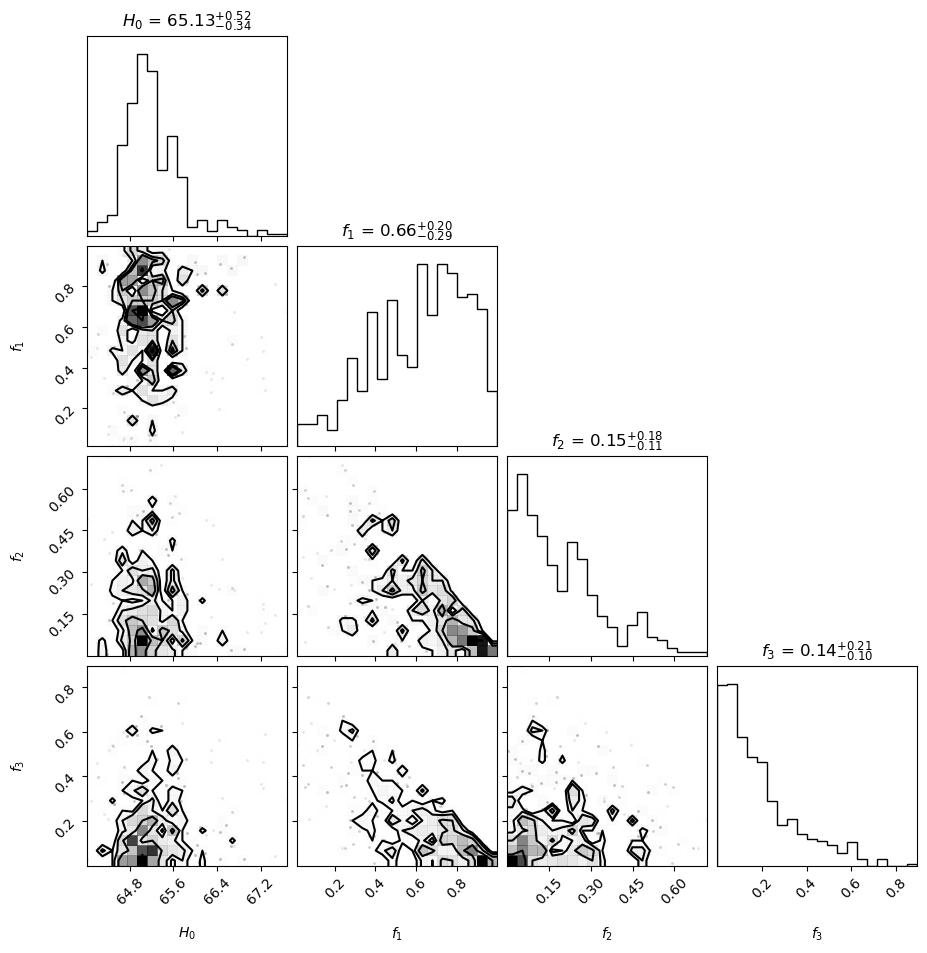

In [47]:
import corner
dres = dsampler.results

dlogZdynesty = dres.logz[-1] 
dlogZerrdynesty = dres.logzerr[-1] 

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)

print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))

fig = corner.corner(dpostsamples, labels=labels, hist_kwargs={'density': True}, show_titles=True)

plt.show()
